## How to use this notebook?


 - To explore the existing example
  - Go to the runtime tool and select "Run all" to execute the entire notebook.
  -Authenticate with Google to access and download data using Google Earth Engine (done in the 2nd code cell).

- To test the model for a new location
  - Update the first code cell by specifying the desired longitude, latitude, and time span.
  - Go to the runtime tool and select "Run all" to execute the entire notebook.

  -Authenticate with Google to access and download data using Google Earth Engine (done in the 2nd code cell).



## Define longitude and latitude, and date range

In [ ]:
# jure
lon_c= 85.869186
lat_c= 27.769457

start_date="2018-01-01" ##'yyyy-mm-dd
end_date="2019-01-01"

## Authenticate google to Download Data

In [ ]:
import ee
ee.Authenticate(auth_mode='notebook')
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=NDmisLykVL6569gmNPYbVCdjF8OeXq3t089Y8GTi7m4&tc=CUE485oqM7woYVofxGb6uzKE9LW7glWvcdCNWjXxIm4&cc=Cif0oYCzoo4q4EIK_xS0zFEg14pgdfYBBUUOGtW1NNY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdLIrYeOqkpoGGXcqFRiRvIUkPp-kqm6tlRZzbqTwCegTnM0HEJxp3Y4juQ

Successfully saved authorization token.


---- **REST is automatic. The final output is visualized at the bottom.**--------------

## Load/Install Libraries

In [ ]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import load_model

!pip install wget
import wget
import ee
import geemap
from skimage.transform import resize

2.15.0
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b8dc42ded6d09df29df56001cfaf45ac0d2e451d271321e5c4f080ca4b5f8a94
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Download Sentinel 2

In [ ]:
my_buffer=0.01

In [ ]:
def calculate_longitude_range(lon_c, lat_c, my_buffer):
    # Initialize variables for longitude range
    xmin = 0
    xmax = 0

    # Determine range based on the sign of lon_c and lat_c
    if lon_c >= 0:
        # If lon_c and lat_c are positive, use buffer latitude
        xmin = lon_c - my_buffer
        xmax = lon_c + my_buffer
        ymin=lat_c-my_buffer
        ymax= lat_c+my_buffer
    else:
        # If lon_c is negative
        xmin = lon_c - (my_buffer+.01)
        xmax = lon_c + (my_buffer+.01)
        ymin=  lat_c-my_buffer/1.5
        ymax= lat_c+my_buffer/1.5

    return xmin, xmax,ymin,ymax

xmin, xmax,ymin,ymax = calculate_longitude_range(lon_c, lat_c, my_buffer)

region = ee.Geometry.BBox(xmin, ymin, xmax, ymax)
fc = ee.FeatureCollection(region)

Map = geemap.Map()
Map.centerObject(fc,15)
Map.addLayer(fc)
Map

Map(center=[27.769456814511088, 85.8691859999852], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Define the image collection and region of interest (fc)
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")
    .filterDate(start_date, end_date)
    .filterBounds(fc)
    # Remove the cloud cover filter
    # Sort the collection based on the "CLOUDY_PIXEL_PERCENTAGE" property in ascending order
    .sort("CLOUDY_PIXEL_PERCENTAGE")
    # Select the bands of interest: B8, B4, B3, B2
    .select(['B8', 'B4', 'B3', 'B2'])
)

# Get the first image from the sorted collection
# This will be the image with the lowest cloud cover
image = collection.first()

vis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
}

Map.addLayer(image.clip(fc), vis, 'Sentinel-2')
Map

Map(center=[27.769456814511088, 85.8691859999852], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# rgb_img = geemap.ee_to_numpy(image.divide(1000), region=fc)
rgb_img = geemap.ee_to_numpy(image, region=fc)
print(rgb_img.shape)


(225, 201, 4)


## Resize Image to 128 by 128

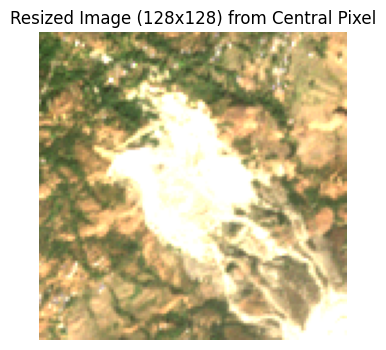

In [ ]:
# Define the desired size for the output image
target_size = 128

# Get the shape of the original image
height, width, channels = rgb_img.shape

# Calculate the coordinates for the central crop
center_x = width // 2
center_y = height // 2

# Calculate the coordinates for the square crop
half_crop_size = target_size // 2

start_x = center_x - half_crop_size
end_x = center_x + half_crop_size
start_y = center_y - half_crop_size
end_y = center_y + half_crop_size

# Crop the central region from the original array
central_crop = rgb_img[start_y:end_y, start_x:end_x]

# Resize the central crop to the desired size (128x128)
resized_img = resize(central_crop, (target_size, target_size, channels), preserve_range=True)

# Convert the resized image back to the original data type
resized_img = resized_img.astype(rgb_img.dtype)

# Plot the resized image
plt.figure(figsize=(4, 4))
plt.imshow(resized_img[:, :, 1:4]/1000)
plt.title("Resized Image (128x128) from Central Pixel")
plt.axis('off')
plt.show()


##Download Elevation and Slope

In [ ]:
dataset = ee.Image('USGS/SRTMGL1_003');
elevation = dataset.select('elevation')
slope = ee.Terrain.slope(elevation)

dem_img = geemap.ee_to_numpy(elevation, region=fc)
resized_dem = resize(dem_img, (128, 128, dem_img.shape[2]), anti_aliasing=True, preserve_range=True)

slope_img = geemap.ee_to_numpy(slope, region=fc)
resized_slope = resize(slope_img, (128, 128, dem_img.shape[2]), anti_aliasing=True, preserve_range=True)

## Preprocess Test Data

In [ ]:
img_mean = [1111.81236406, 824.63171476, 663.41636217, 445.17289745, 645.8582926, 1547.73508126, 1960.44401001, 1941.32229668, 674.07572865, 9.04787384, 1113.98338755, 519.90397929, 20.29228266, 772.83144788]
rgb_img_n = np.zeros((128, 128, 4))

rgb_img_n[:, :, 0] = resized_img[:, :, 0] / img_mean[7]
rgb_img_n[:, :, 1] = resized_img[:, :, 1] / img_mean[3]
rgb_img_n[:, :, 2] = resized_img[:, :, 2] /img_mean[2]
rgb_img_n[:, :, 3] = resized_img[:, :, 3] / img_mean[1]
# rgb_img_n[np.isnan(rgb_img_n)] = 0.000001
slope=resized_slope/ img_mean[12]
dem=resized_dem/ img_mean[13]

data_ndvi = np.divide(rgb_img_n[:, :, 0] - rgb_img_n[:, :, 1],np.add(rgb_img_n[:, :, 0], rgb_img_n[:, :, 1]))

mid_rgb_test = rgb_img_n[:, :, 1:4].max() / 2.0
mid_slope_test = slope.max() / 2.0
mid_elevation_test = dem.max() / 2.0

j=0
TEST_XX = np.zeros((1,128, 128, 6))
TEST_XX[j,:, :, 0] = 1 - rgb_img_n[:, :, 1] / mid_rgb_test #RED
TEST_XX[j,:, :, 1] = 1 - rgb_img_n[:, :, 2] / mid_rgb_test #GREEN
TEST_XX[j,:, :, 2] = 1 - rgb_img_n[:, :, 3] / mid_rgb_test #BLUE
TEST_XX[j,:, :, 3] = data_ndvi #NDVI
TEST_XX[j,:, :, 4] = 1- slope[:, :, 0]/ mid_slope_test #SLOPE
TEST_XX[j,:, :, 5] = 1 - dem[:, :, 0]/ mid_elevation_test #ELEVATION

## Visualize Test Data

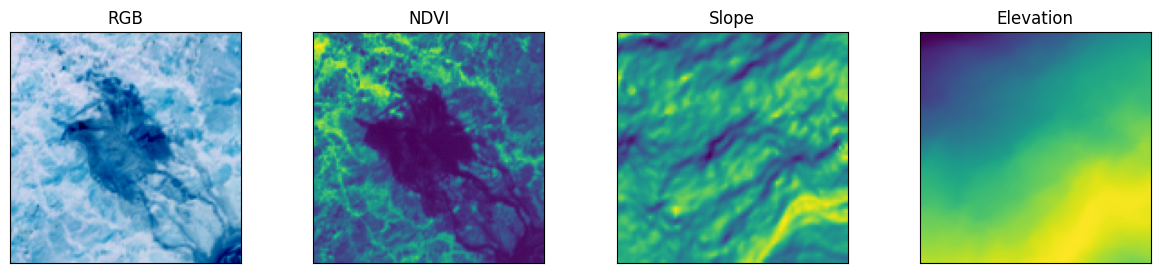

In [ ]:
titles = ["RGB", "NDVI", "Slope", "Elevation"]
data_plot = [TEST_XX[j,:, :, 0:3], TEST_XX[j,:, :, 3], TEST_XX[j,:, :, 4], TEST_XX[j,:, :, 5]]

fig, axes = plt.subplots(1, 4, figsize=(15, 3))

for ax, title, data in zip(axes, titles, data_plot):
    ax.set_title(title)
    ax.imshow(data)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Load Model

In [ ]:
wget.download('https://raw.githubusercontent.com/amrit-thapa-2044/GEOS_F659_predict_landslide_himalaya/main/utils.py')
wget.download('https://raw.githubusercontent.com/amrit-thapa-2044/GEOS_F659_predict_landslide_himalaya/main/best_model_500_binary_crossentropy_flip.h5')
import utils
model= tf.keras.models.load_model('./best_model_500_binary_crossentropy_flip.h5', custom_objects={'f1_m': utils.f1_m, 'precision_m': utils.precision_m,'recall_m':utils.recall_m})
# model.summary()

## Make Prediction

In [ ]:
threshold = 0.5
pred_img_test1= model.predict(TEST_XX)
pred_img_test1 = (pred_img_test1 > threshold).astype(np.uint8)

1/1 [==============================] - 1s 520ms/step


## Visualize Prediction

Text(0.5, 1.0, 'Predicted Mask')

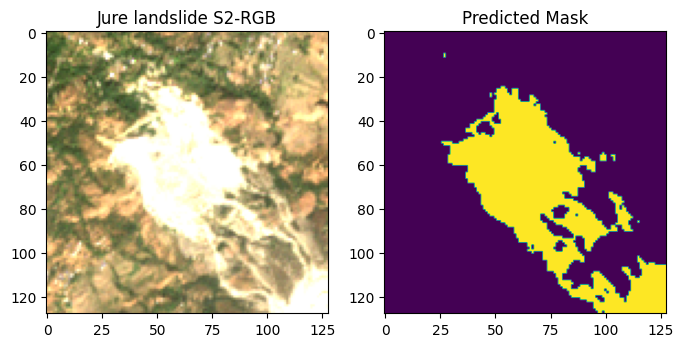

In [ ]:
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(8,4))
ax1.imshow(resized_img[:, :, 1:4]/1000)
ax1.set_title('Jure landslide S2-RGB')

ax2.imshow(pred_img_test1[j, :, :, 0])
ax2.set_title("Predicted Mask")